# Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from wordcloud import WordCloud
from PIL import Image
import plotly.figure_factory as ff
import warnings
warnings.filterwarnings('ignore')



# Load and Check the Dataset

In [2]:
data = pd.read_csv('Reviews.csv')
data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [4]:
print('Checking the Dataset: ')
print('\n')
data.info()
print('\n')
print('Checking for Rows and Columns: ')
data.shape

Checking the Dataset: 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Checking for Rows and Columns: 


(568454, 10)

# Checking for Missing Values

In [5]:
print('Missing Values in the Data: ')
missing_values = data.isnull().sum()
print(missing_values)
print('\nDuplicate Entries')
duplicates = data.duplicated().sum()
print(duplicates)



Missing Values in the Data: 
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

Duplicate Entries
0


In [6]:
data['Sentiment'] = data['Score'].apply(lambda score: 'positive' if score >3 else ('negative' if score <3 else 'neutral'))

In [7]:
data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'Sentiment'],
      dtype='object')

In [8]:
reduced_data = data.sample(n=50000, random_state=42)

In [9]:
# Initialise Stemmer, Lemmatiser and Stopwords
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def process_text(text):
    # Clean HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text(separator=' ')

    # convert to lowercase
    cleaned_text = cleaned_text.lower()

    # Tokenization
    words = word_tokenize(cleaned_text)

    # Remove stopwords and non-alphabetic words, Stemming and Lemmatization
    filtered_words = [
        lemmatizer.lemmatize(stemmer.stem(word))
        for word in words
        if word not in stop_words and word.isalpha()
    ]
    return ' '.join(filtered_words)


In [10]:
reduced_data['Processed Text'] = reduced_data['Text'].apply(process_text)

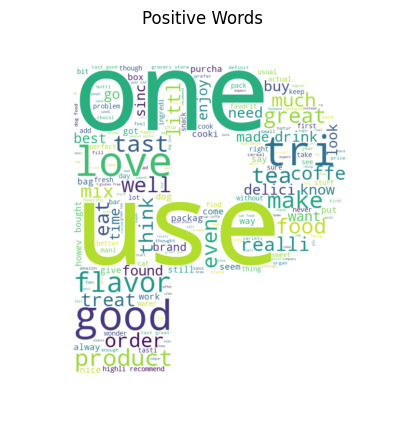

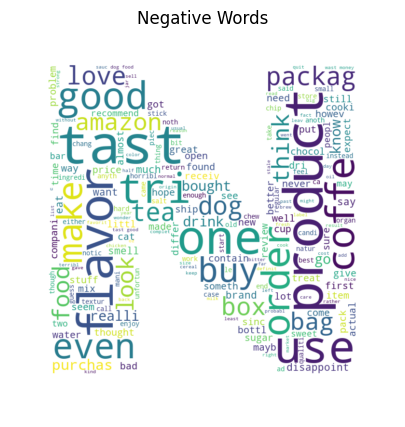

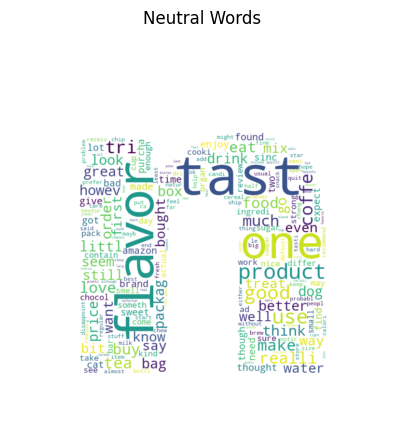

In [11]:
# Loading Image Path
positive_image_path = 'positive.png'
negative_image_path = 'negative.png'
neutral_image_path = 'neutrall.png'

# Load masks
positive_mask = np.array(Image.open(positive_image_path))
negative_mask = np.array(Image.open(negative_image_path))
neutral_mask = np.array(Image.open(neutral_image_path))

def generate_wordcloud(text, title, mask):
    wordcloud = WordCloud(width=800, height=400, background_color='white', mask=mask).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Use already processed text for word cloud generation
positive_text = ' '.join(reduced_data[reduced_data['Sentiment'] == 'positive']['Processed Text'])
negative_text = ' '.join(reduced_data[reduced_data['Sentiment'] == 'negative']['Processed Text'])
neutral_text = ' '.join(reduced_data[reduced_data['Sentiment'] == 'neutral']['Processed Text'])

# Generate word clouds with masks
generate_wordcloud(positive_text, 'Positive Words', positive_mask)
generate_wordcloud(negative_text, 'Negative Words', negative_mask)
generate_wordcloud(neutral_text, 'Neutral Words', neutral_mask)

# Initial Sentiment Distribution

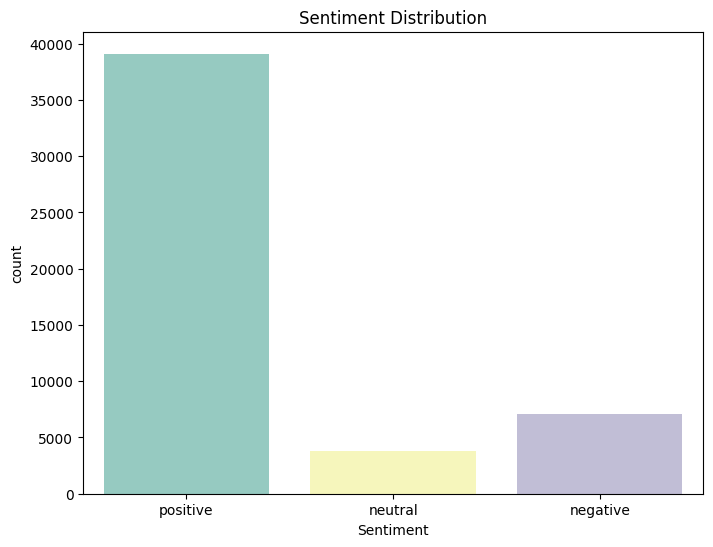

In [12]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=reduced_data, palette='Set3')
plt.title('Sentiment Distribution')
plt.show()

# Split the Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(reduced_data['Processed Text'], reduced_data['Sentiment'], test_size=0.2, random_state=42, stratify=reduced_data['Sentiment'])

# Vectorise the Text

In [14]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)


# Balancing the distribution with SMOTE by oversampling the minority class

# Balance the Classes

In [15]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vectorized, y_train)


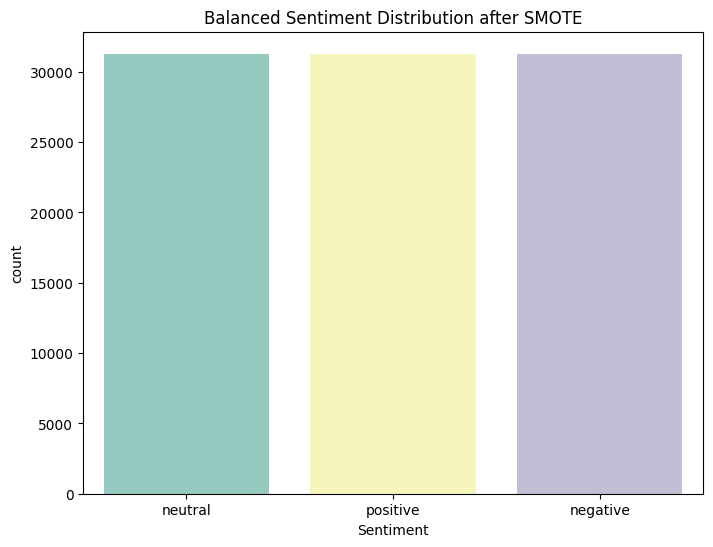

In [16]:
# Convert y_train_resampled to DataFrame for plotting
resampled_df = pd.DataFrame(y_train_resampled, columns=['Sentiment'])

# Plot the distribution of the classes after SMOTE
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment', data=resampled_df, palette='Set3')
plt.title('Balanced Sentiment Distribution after SMOTE')
plt.show()

# Model Training and Evaluation

# Machine Learning

     --> Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Example with Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)
y_pred = lr_model.predict(X_test_vectorized)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('\nClassification Report :\n', classification_report(y_test, y_pred))


Accuracy:  0.7769

Classification Report :
               precision    recall  f1-score   support

    negative       0.57      0.67      0.62      1421
     neutral       0.23      0.43      0.30       758
    positive       0.94      0.83      0.88      7821

    accuracy                           0.78     10000
   macro avg       0.58      0.64      0.60     10000
weighted avg       0.83      0.78      0.80     10000



    --> Random Forest Classifier

In [21]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = rf_model.predict(X_test_vectorized)

print('Random Forest Accuracy: ', accuracy_score(y_test, y_pred_rf))
print('\nRandom Forest Classification Report :\n', classification_report(y_test, y_pred_rf))



Random Forest Accuracy:  0.8257

Random Forest Classification Report :
               precision    recall  f1-score   support

    negative       0.64      0.49      0.56      1421
     neutral       0.47      0.17      0.25       758
    positive       0.86      0.95      0.90      7821

    accuracy                           0.83     10000
   macro avg       0.66      0.54      0.57     10000
weighted avg       0.80      0.83      0.80     10000



    --> Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()
nb_model.fit(X_train_resampled, y_train_resampled)
y_pred_nb = nb_model.predict(X_test_vectorized)

print('Naive Bayes Accuracy: ', accuracy_score(y_test, y_pred_nb))
print('\nNaive Bayes Classification Report :\n', classification_report(y_test, y_pred_nb))

Naive Bayes Accuracy:  0.7126

Naive Bayes Classification Report :
               precision    recall  f1-score   support

    negative       0.51      0.64      0.57      1421
     neutral       0.18      0.48      0.26       758
    positive       0.94      0.75      0.83      7821

    accuracy                           0.71     10000
   macro avg       0.54      0.62      0.56     10000
weighted avg       0.82      0.71      0.75     10000



    --> Recurrent Neural Network

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform y_train and y_test to convert them to integers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Tokenize and pad sequences for RNN
tokenizer = Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

# Define, compile, and train the RNN model
model = Sequential([
    Embedding(input_dim=5000, output_dim=64, input_length=100),
    SimpleRNN(64),
    Dense(3, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model with the encoded labels
model.fit(X_train_padded, y_train_encoded, epochs=5, validation_data=(X_test_padded, y_test_encoded))

from sklearn.metrics import classification_report

# Make predictions on the test data
y_pred_probs = model.predict(X_test_padded)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Get the classification report
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)

print('RNN Classification Report :\n', report)



Epoch 1/5
1250/1250 [==============================] - 27s 21ms/step - loss: 0.6691 - accuracy: 0.7821 - val_loss: 0.6620 - val_accuracy: 0.7828
Epoch 2/5
1250/1250 [==============================] - 22s 18ms/step - loss: 0.6493 - accuracy: 0.7873 - val_loss: 0.6791 - val_accuracy: 0.7798
Epoch 3/5
1250/1250 [==============================] - 22s 18ms/step - loss: 0.6285 - accuracy: 0.7967 - val_loss: 0.6763 - val_accuracy: 0.7762
Epoch 4/5
1250/1250 [==============================] - 22s 17ms/step - loss: 0.6213 - accuracy: 0.7980 - val_loss: 0.6903 - val_accuracy: 0.7745
Epoch 5/5
313/313 [==============================] - 2s 5ms/step
RNN Classification Report :
               precision    recall  f1-score   support

    negative       0.23      0.02      0.04      1421
     neutral       0.22      0.03      0.05       758
    positive       0.79      0.98      0.87      7821

    accuracy                           0.77     10000
   macro avg       0.41      0.34      0.32     10000


    --> Vader

In [24]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Instantiate the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Analyzing sentiment of the test set
vader_results = []
for text in X_test:  # Assuming X_test contains the text data
    scores = sid.polarity_scores(text)
    if scores['compound'] >= 0.05:
        vader_results.append('positive')
    elif scores['compound'] <= -0.05:
        vader_results.append('negative')
    else:
        vader_results.append('neutral')

# Calculate accuracy and other metrics
print('Vader Accuracy: ', accuracy_score(y_test, vader_results))
print('\nVader Classification Report :\n', classification_report(y_test, vader_results))


Vader Accuracy:  0.7679

Vader Classification Report :
               precision    recall  f1-score   support

    negative       0.49      0.24      0.32      1421
     neutral       0.11      0.05      0.07       758
    positive       0.82      0.93      0.87      7821

    accuracy                           0.77     10000
   macro avg       0.47      0.41      0.42     10000
weighted avg       0.72      0.77      0.73     10000

